![](https://mivia.unisa.it/onfire2023/assets/img/iciap_logo.jpg)
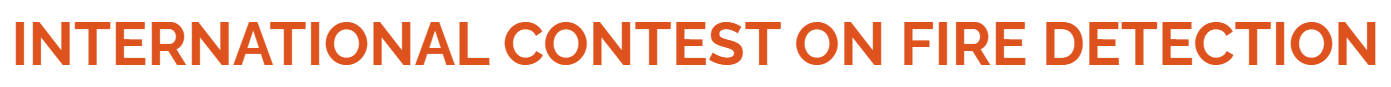

Dear Participant,

Thanks for your participation to ONFIRE Contest 2023.

Please download the following files:
- Training videos: https://drive.google.com/file/d/1tEz2wVQjPp1MjVHZLa-Z3uyVBnwljgGF/view?usp=sharing
- Training annotations: https://drive.google.com/file/d/123AcAQCldRNE6iKpXuCaVtsaR3uHIOeN/view?usp=sharing
- Code example: https://drive.google.com/file/d/1rXMCtpus2i2UDdSBD9RwWAxnT0wrrXOk/view?usp=sharing

Please remind that:
- The deadline for the submission of the methods is 21st July, 2023. The submission must be done with an email in which the participants share (directly or with external links) the trained model, the code and the report. The participants can receive the training set and its annotations by sending an email to onfire2023@unisa.it, in which they also communicate the name of the team.
- The participants can use these training samples and annotations, but also additional videos.
- The participants must submit their trained model and their code by carefully following the detailed instructions reported in the website. 
- The participants are strongly encouraged to submit a contest paper to ICIAP 2023, whose deadline is 28th July, 2023. The contest paper must be also sent by email to the organizers. Otherwise, the participants must produce a brief PDF report of the proposed method.
- The detailed instructions of the proposed method can be downloaded here: https://mivia.unisa.it/onfire2023/

In [ ]:
# You can follow this tutorial for more information - https://www.tutorialspoint.com/google_colab/index.htm
# You can also see this video - https://www.youtube.com/watch?v=inN8seMm7UI

# Mount your Drive - After doing this step, your Google Drive folders are accessible from Google Colab.
from google.colab import drive
drive.mount('/content/gdrive')

#Download and unzip

In [23]:
import gdown
def download_google_file(shader_url, output_name):
  id_url = "https://drive.google.com/uc?id=" + shader_url.split("/")[5]
  gdown.download(id_url, output_name)

In [ ]:
download_google_file("https://drive.google.com/file/d/1tEz2wVQjPp1MjVHZLa-Z3uyVBnwljgGF/view?usp=sharing", "VIDEOS.zip")
!unzip VIDEOS.zip

In [ ]:
download_google_file("https://drive.google.com/file/d/123AcAQCldRNE6iKpXuCaVtsaR3uHIOeN/view?usp=sharing", "GT.zip")
!unzip GT.zip
!mkdir -p GT/TRAINING_SET
!mv GT_TRAINING_SET_CL0 GT/TRAINING_SET/0
!mv GT_TRAINING_SET_CL1 GT/TRAINING_SET/1

In [ ]:
download_google_file("https://drive.google.com/file/d/1rXMCtpus2i2UDdSBD9RwWAxnT0wrrXOk/view?usp=sharing", "test_code.zip")
!unzip test_code.zip

#Extract frames from video files

In [4]:
videos_path = "TRAINING_SET"
frames_path = "FRAMES"

In [54]:
!rm -R FRAMES/TRAINING_SET/

We use ffmpeg to faster the frame extraction

In [55]:
import cv2, os, argparse, glob, PIL, tqdm

def extract_frames(video):
    # Process the video
    ret = True
    cap = cv2.VideoCapture(video)
    f = 0
    while ret:
        ret, img = cap.read()
        if ret:
            f += 1
            PIL.Image.fromarray(img).save(os.path.join(frames_path, video, "{:05d}.jpg".format(f)))
    cap.release()

# For all the videos
file_list = [path for path in glob.glob(os.path.join(videos_path,"**"), recursive=True)
             if os.path.isfile(path)]
print(file_list)
for video in tqdm.tqdm(file_list):
  if os.path.isdir(os.path.join(frames_path, video)):
    continue
  
  os.makedirs(os.path.join(frames_path, video))
  #extract_frames(video)
  os.system("ffmpeg -i {} -r 1/1 {}/{}/$Frame{}.jpg".format(video, frames_path, video, "%05d"))


['TRAINING_SET/1/Video38.mp4', 'TRAINING_SET/1/Video260.mp4', 'TRAINING_SET/1/Video3.mp4', 'TRAINING_SET/1/Video40.mp4', 'TRAINING_SET/1/Video29.mp4', 'TRAINING_SET/1/Video172.mp4', 'TRAINING_SET/1/Video229.mp4', 'TRAINING_SET/1/Video33.mp4', 'TRAINING_SET/1/Video140.mp4', 'TRAINING_SET/1/Video75_4.mp4', 'TRAINING_SET/1/Video122.mp4', 'TRAINING_SET/1/Video71.mp4', 'TRAINING_SET/1/Video201.mp4', 'TRAINING_SET/1/Video59.mp4', 'TRAINING_SET/1/Video200.mp4', 'TRAINING_SET/1/Video234.mp4', 'TRAINING_SET/1/Video113.mp4', 'TRAINING_SET/1/Video144.mp4', 'TRAINING_SET/1/Video197.mp4', 'TRAINING_SET/1/Video109.mp4', 'TRAINING_SET/1/Video138.mp4', 'TRAINING_SET/1/Video184.mp4', 'TRAINING_SET/1/Video7.mp4', 'TRAINING_SET/1/Video252.mp4', 'TRAINING_SET/1/Video251.mp4', 'TRAINING_SET/1/Video28.mp4', 'TRAINING_SET/1/Video253.mp4', 'TRAINING_SET/1/Video155.mp4', 'TRAINING_SET/1/Video15.mp4', 'TRAINING_SET/1/Video153.mp4', 'TRAINING_SET/1/Video247.mp4', 'TRAINING_SET/1/Video105.mp4', 'TRAINING_SET/1/Vi

100%|██████████| 312/312 [00:00<00:00, 536.21it/s]


#PyTorch dataset

![](https://albumentations.ai/assets/img/custom/albumentations_logo.png)

We use [Albumentations](https://albumentations.ai/) to augment a set of frames with the same augmentation parameters.
![](https://albumentations.ai/assets/img/custom/top_image.jpg)

We use strprtf to parse RTF files

In [8]:
!pip install striprtf

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [41]:
import os
import os.path
import numpy as np
from PIL import Image
from torchvision import transforms
import torch
from typing import List, Union, Tuple, Any
from striprtf.striprtf import rtf_to_text
import albumentations


class VideoRecord(object):
    """
    Helper class for class VideoFrameDataset. This class
    represents a video sample's metadata.

    Args:
        root_datapath: the system path to the root folder of the videos.
        row: A list with four or more elements where
             1) The first element is the path to the video sample's frames excluding
             the root_datapath prefix
             2) The  second element is the starting frame id of the video
             3) The third element is the inclusive ending frame id of the video
             4) The fourth element is the label index.
             5) any following elements are labels in the case of multi-label classification
    """
    def __init__(self, row, root_datapath):
        self._data = row
        self._path = os.path.join(root_datapath, row[0])

    @property
    def path(self) -> str:
        return self._path

    @property
    def num_frames(self) -> int:
        return self.end_frame - self.start_frame + 1  # +1 because end frame is inclusive

    @property
    def start_frame(self) -> int:
        return int(self._data[1])

    @property
    def end_frame(self) -> int:
        return int(self._data[2])

    @property
    def label(self) -> Union[int, List[int]]:
        # just one label_id
        if len(self._data) == 4:
            return int(self._data[3])
        # sample associated with multiple labels
        else:
            return [int(label_id) for label_id in self._data[3:]]


class VideoFrameDataset(torch.utils.data.Dataset):
    r"""
    A highly efficient and adaptable dataset class for videos.
    Instead of loading every frame of a video,
    loads x RGB frames of a video (sparse temporal sampling) and evenly
    chooses those frames from start to end of the video, returning
    a list of x PIL images or ``FRAMES x CHANNELS x HEIGHT x WIDTH``
    tensors.

    More specifically, the frame range [START_FRAME, END_FRAME] is divided into NUM_SEGMENTS
    segments and FRAMES_PER_SEGMENT consecutive frames are taken from each segment.

    Note:
        A demonstration of using this class can be seen
        in ``demo.py``
        https://github.com/RaivoKoot/Video-Dataset-Loading-Pytorch

    Note:
        This dataset broadly corresponds to the frame sampling technique
        introduced in ``Temporal Segment Networks`` at ECCV2016
        https://arxiv.org/abs/1608.00859.

    Args:
        root_path: The root path in which video folders lie.
                   this is ROOT_DATA from the description above.
        num_segments: The number of segments the video should
                      be divided into to sample frames from.
        frames_per_segment: The number of frames that should
                            be loaded per segment. For each segment's
                            frame-range, a random start index or the
                            center is chosen, from which frames_per_segment
                            consecutive frames are loaded.
        imagefile_template: The image filename template that video frame files
                            have inside of their video folders as described above.
        transform: Transform pipeline that receives a list of numpy images/frames.
        test_mode: If True, frames are taken from the center of each
                   segment, instead of a random location in each segment.

    """
    def __init__(self,
                 root_path: str,
                 num_segments: int = 3,
                 frames_per_segment: int = 1,
                 imagefile_template: str='{:05d}.jpg',
                 transform=None,
                 totensor=True,
                 test_mode: bool = False):
        super(VideoFrameDataset, self).__init__()

        self.root_path = root_path
        self.num_segments = num_segments
        self.frames_per_segment = frames_per_segment
        self.imagefile_template = imagefile_template
        self.test_mode = test_mode

        if transform is None:
            self.transform = None
        else:
            additional_targets = {}
            for i in range(self.num_segments * self.frames_per_segment - 1):
                additional_targets["image%d" % i] = "image"
            self.transform = albumentations.Compose([transform],
                                                    additional_targets=additional_targets,
                                                    p=1)
        self.totensor = totensor
        self.totensor_transform = ImglistOrdictToTensor()

        self._parse_annotationfile()
        self._sanity_check_samples()

    def _load_image(self, directory: str, idx: int) -> Image.Image:
        return np.asarray(Image.open(os.path.join(directory, self.imagefile_template.format(idx))).convert('RGB'))

    def _parse_annotationfile(self):
        self.video_list = []
        for class_name in os.listdir(self.root_path):
            for video_name in os.listdir(os.path.join(self.root_path, class_name)):
                frames_dir = os.path.join(self.root_path, class_name, video_name)
                if os.path.isdir(frames_dir):
                    frame_path = os.path.join(class_name, video_name)
                    end_frame = len(os.listdir(frames_dir))

                    annotation_path = frames_dir\
                        .replace("\\", "/") \
                        .replace("FRAMES/", "GT/") \
                        .replace(".mp4", ".rtf")

                    with open(annotation_path, 'r') as file:
                        text = rtf_to_text(file.read())
                    if len(text):
                        label = 1
                        start_frame = int(text.split(",")[0])
                        if start_frame == 0:
                          start_frame = 1
                    else:
                        label = 0
                        start_frame = 1

                    self.video_list.append(VideoRecord(
                        [frame_path, start_frame, end_frame, label],
                        self.root_path))

    def _sanity_check_samples(self):
        for record in self.video_list:
            if record.num_frames <= 0 or record.start_frame == record.end_frame:
                print(f"\nDataset Warning: video {record.path} seems to have zero RGB frames on disk!\n")

            elif record.num_frames < (self.num_segments * self.frames_per_segment):
                print(f"\nDataset Warning: video {record.path} has {record.num_frames} frames "
                      f"but the dataloader is set up to load "
                      f"(num_segments={self.num_segments})*(frames_per_segment={self.frames_per_segment})"
                      f"={self.num_segments * self.frames_per_segment} frames. Dataloader will throw an "
                      f"error when trying to load this video.\n")

    def _get_start_indices(self, record: VideoRecord) -> 'np.ndarray[int]':
        """
        For each segment, choose a start index from where frames
        are to be loaded from.

        Args:
            record: VideoRecord denoting a video sample.
        Returns:
            List of indices of where the frames of each
            segment are to be loaded from.
        """
        # choose start indices that are perfectly evenly spread across the video frames.
        if self.test_mode:
            distance_between_indices = (record.num_frames - self.frames_per_segment + 1) / float(self.num_segments)

            start_indices = np.array([int(distance_between_indices / 2.0 + distance_between_indices * x)
                                      for x in range(self.num_segments)])
        # randomly sample start indices that are approximately evenly spread across the video frames.
        else:
            max_valid_start_index = (record.num_frames - self.frames_per_segment + 1) // self.num_segments

            start_indices = np.multiply(list(range(self.num_segments)), max_valid_start_index) + \
                      np.random.randint(max_valid_start_index, size=self.num_segments)

        return start_indices

    def __getitem__(self, idx: int) -> Union[
        Tuple[List[Image.Image], Union[int, List[int]]],
        Tuple['torch.Tensor[num_frames, channels, height, width]', Union[int, List[int]]],
        Tuple[Any, Union[int, List[int]]],
        ]:
        """
        For video with id idx, loads self.NUM_SEGMENTS * self.FRAMES_PER_SEGMENT
        frames from evenly chosen locations across the video.

        Args:
            idx: Video sample index.
        Returns:
            A tuple of (video, label). Label is either a single
            integer or a list of integers in the case of multiple labels.
            Video is either 1) a list of PIL images if no transform is used
            2) a batch of shape (NUM_IMAGES x CHANNELS x HEIGHT x WIDTH) in the range [0,1]
            if the transform "ImglistToTensor" is used
            3) or anything else if a custom transform is used.
        """
        record: VideoRecord = self.video_list[idx]

        frame_start_indices: 'np.ndarray[int]' = self._get_start_indices(record)

        return self._get(record, frame_start_indices)

    def _get(self, record: VideoRecord, frame_start_indices: 'np.ndarray[int]') -> Union[
        Tuple[List[Image.Image], Union[int, List[int]]],
        Tuple['torch.Tensor[num_frames, channels, height, width]', Union[int, List[int]]],
        Tuple[Any, Union[int, List[int]]],
        ]:
        """
        Loads the frames of a video at the corresponding
        indices.

        Args:
            record: VideoRecord denoting a video sample.
            frame_start_indices: Indices from which to load consecutive frames from.
        Returns:
            A tuple of (video, label). Label is either a single
            integer or a list of integers in the case of multiple labels.
            Video is either 1) a list of PIL images if no transform is used
            2) a batch of shape (NUM_IMAGES x CHANNELS x HEIGHT x WIDTH) in the range [0,1]
            if the transform "ImglistToTensor" is used
            3) or anything else if a custom transform is used.
        """

        frame_start_indices = frame_start_indices + record.start_frame
        images = list()

        # from each start_index, load self.frames_per_segment
        # consecutive frames
        for start_index in frame_start_indices:
            frame_index = int(start_index)

            # load self.frames_per_segment consecutive frames
            for _ in range(self.frames_per_segment):
                image = self._load_image(record.path, frame_index)
                images.append(image)

                if frame_index < record.end_frame:
                    frame_index += 1

        if self.transform is not None:
            transform_input = {"image": images[0]}
            for i, image in enumerate(images[1:]):
                transform_input["image%d" % i] = image
            images = self.transform(**transform_input)

        if self.totensor:
            images = self.totensor_transform(images)
        return images, record.label

    def __len__(self):
        return len(self.video_list)


class ImglistOrdictToTensor(torch.nn.Module):
    """
    Converts a list or a dict of numpy images to a torch.FloatTensor
    of shape (NUM_IMAGES x CHANNELS x HEIGHT x WIDTH).
    Can be used as first transform for ``VideoFrameDataset``.
    """
    @staticmethod
    def forward(img_list_or_dict):
        """
        Converts each numpy image in a list or a dict to
        a torch Tensor and stacks them into a single tensor.

        Args:
            img_list_or_dict: list or dict of numpy images.
        Returns:
            tensor of size ``NUM_IMAGES x CHANNELS x HEIGHT x WIDTH``
        """
        if isinstance(img_list_or_dict, list):
            return torch.stack([transforms.functional.to_tensor(img)
                                for img in img_list_or_dict])
        else:
            return torch.stack([transforms.functional.to_tensor(img_list_or_dict[k])
                                for k in img_list_or_dict.keys()])


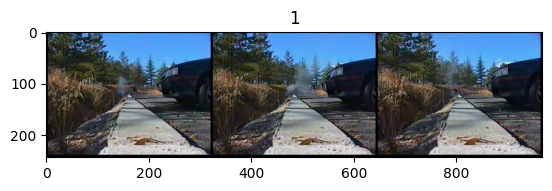

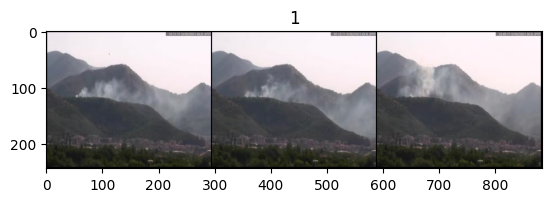

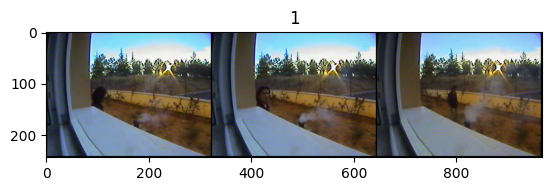

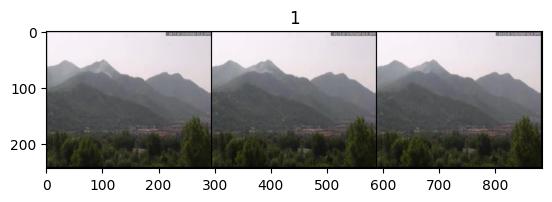

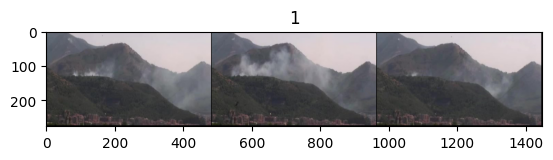

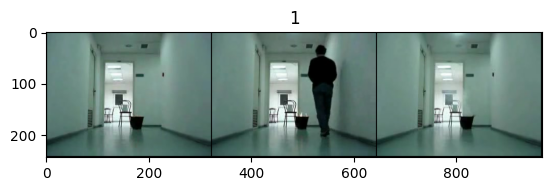

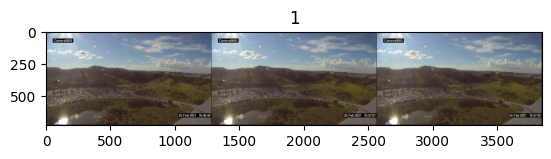

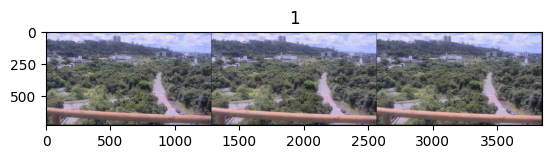

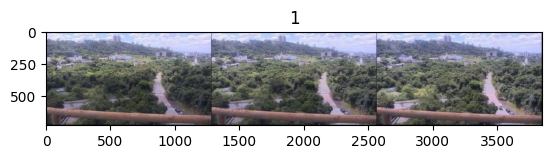

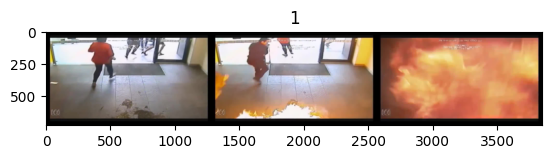

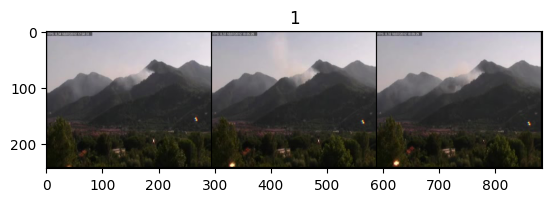

In [59]:
def demo_visualization():
    from torchvision.utils import make_grid
    import matplotlib.pyplot as plt

    # Augmentation
    augmentation = albumentations.OneOf([
        albumentations.HorizontalFlip(p=1.),
        ], p=.5)

    # Dataset with augmentation for visualization
    dataset = VideoFrameDataset(root_path="FRAMES/TRAINING_SET/",
                                num_segments=3,
                                frames_per_segment=1,
                                transform=augmentation,
                                )
    counter = 0
    for X, y in dataset:
        if counter > 10:
            break
        plt.figure()
        plt.imshow(make_grid(X).numpy().transpose((1, 2, 0)))
        plt.title(y)
        plt.show()
        counter += 1



demo_visualization()

In [43]:
def demo_training():
    from tqdm import tqdm
    from torch.utils.data import DataLoader

    # Preprocessing and augmentation
    preprocessing = albumentations.Sequential([
        albumentations.Resize(height=224, width=224, always_apply=True),
        albumentations.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225],
                                 max_pixel_value=255.,
                                 always_apply=True),
    ])

    augmentation = albumentations.OneOf([
        albumentations.HorizontalFlip(p=1.),
        ], p=.5)

    # Dataset for training
    dataset = VideoFrameDataset(root_path="FRAMES/TRAINING_SET/",
                                num_segments=3,
                                frames_per_segment=1,
                                transform=albumentations.Compose([
                                    preprocessing,
                                    augmentation],
                                    p=1.,
                                )
                                )

    print(dataset, "\nelements:", len(dataset))
    X, y = dataset[0]
    print('first element data', X.shape, X.min(), X.max(), X.mean(), X.std(), '\nlabel', y)
    return dataset

dataset_train = demo_training()

elements: 312
first element data torch.Size([3, 3, 224, 224]) tensor(-2.1179) tensor(2.6400) tensor(-0.4125) tensor(1.1677) 
label 1


In [46]:
from torch.utils.data import DataLoader
dataloader_train = DataLoader(dataset_train, shuffle=True,
                              batch_size=2, num_workers=4, pin_memory=True)
print(dataloader_train, "\nbatches:", len(dataloader_train))

for X, y in tqdm.tqdm(dataloader_train):
  counter +=1
  print('batch data', X.shape, X.min(), X.max(), X.mean(), X.std(), '\nlabel', y)

batches: 156


  2%|▏         | 3/156 [00:01<00:54,  2.79it/s]

batch data torch.Size([2, 3, 3, 224, 224]) tensor(-2.1179) tensor(2.6400) tensor(-0.1771) tensor(1.1303) 
label tensor([1, 1])
batch data torch.Size([2, 3, 3, 224, 224]) tensor(-2.0323) tensor(1.9603) tensor(-0.2276) tensor(1.1563) 
label tensor([1, 1])
batch data torch.Size([2, 3, 3, 224, 224]) tensor(-2.1179) tensor(2.6400) tensor(-0.2731) tensor(1.2488) 
label tensor([0, 1])


  3%|▎         | 5/156 [00:01<00:33,  4.47it/s]

batch data torch.Size([2, 3, 3, 224, 224]) tensor(-2.0837) tensor(2.5354) tensor(-0.0623) tensor(1.0498) 
label tensor([0, 1])
batch data torch.Size([2, 3, 3, 224, 224]) tensor(-2.1179) tensor(2.6400) tensor(-0.5080) tensor(1.3067) 
label tensor([1, 0])
batch data torch.Size([2, 3, 3, 224, 224]) tensor(-2.1179) tensor(2.6226)

  4%|▍         | 7/156 [00:01<00:22,  6.48it/s]

 tensor(-0.0318) tensor(1.0472) 
label tensor([1, 1])
batch data torch.Size([2, 3, 3, 224, 224]) tensor(-2.0837) tensor(2.6400) tensor(0.1555) tensor(0.9972) 
label tensor([1, 0])
batch data torch.Size([2, 3, 3, 224, 224]) tensor(-2.1179) tensor(2.6400) tensor(0.6251) tensor(0.9888) 
label tensor([1, 1])


  6%|▌         | 9/156 [00:01<00:17,  8.52it/s]

batch data torch.Size([2, 3, 3, 224, 224]) tensor(-1.9295) tensor(2.1633) tensor(-0.4118) tensor(0.7730) 
label tensor([0, 0])
batch data torch.Size([2, 3, 3, 224, 224]) tensor(-2.1179) tensor(2.6400) tensor(-0.0883) tensor(1.0126) 
label tensor([1, 1])


  7%|▋         | 11/156 [00:02<00:19,  7.30it/s]

batch data torch.Size([2, 3, 3, 224, 224]) tensor(-2.1179) tensor(2.6400) tensor(0.1438) tensor(1.0312) 
label tensor([1, 1])
batch data torch.Size([2, 3, 3, 224, 224]) tensor(-1.8953) tensor(2.5877) tensor(-0.0418) tensor(1.0733) 
label tensor([1, 0])


  9%|▉         | 14/156 [00:02<00:19,  7.44it/s]

batch data torch.Size([2, 3, 3, 224, 224]) tensor(-2.1179) tensor(2.6400) tensor(0.6480) tensor(1.1331) 
label tensor([1, 1])
batch data torch.Size([2, 3, 3, 224, 224]) tensor(-2.1008) tensor(2.6400) tensor(-0.2993) tensor(1.2773) 
label tensor([1, 0])


 10%|▉         | 15/156 [00:03<00:30,  4.68it/s]

batch data torch.Size([2, 3, 3, 224, 224]) tensor(-2.1179) tensor(2.6400) tensor(-0.0567) tensor(1.1324) 
label tensor([0, 1])
batch data torch.Size([2, 3, 3, 224, 224]) tensor(-2.1179) tensor(2.6400) tensor(-0.7367) tensor(1.2021) 
label tensor([1, 0])


 12%|█▏        | 19/156 [00:03<00:18,  7.61it/s]

batch data torch.Size([2, 3, 3, 224, 224]) tensor(-1.9809) tensor(2.6226) tensor(-0.1123) tensor(1.1944) 
label tensor([0, 1])
batch data torch.Size([2, 3, 3, 224, 224]) tensor(-2.1179) tensor(2.6400) tensor(-0.2655) tensor(1.1096) 
label tensor([1, 1])
batch data torch.Size([2, 3, 3, 224, 224]) tensor(-2.0323) tensor(2.6400) tensor(0.0502) tensor(1.4527) 
label tensor([0, 1])


 13%|█▎        | 21/156 [00:03<00:15,  8.76it/s]

batch data torch.Size([2, 3, 3, 224, 224]) tensor(-2.1179) tensor(2.6400) tensor(0.6962) tensor(1.1055) 
label tensor([1, 1])
batch data torch.Size([2, 3, 3, 224, 224]) tensor(-2.1179) tensor(2.6400) tensor(-0.4013) tensor(1.1022) 
label tensor([1, 0])


 17%|█▋        | 26/156 [00:04<00:15,  8.24it/s]

batch data torch.Size([2, 3, 3, 224, 224]) tensor(-2.1179) tensor(2.6400) tensor(-0.9492) tensor(1.2562) 
label tensor([1, 0])
batch data torch.Size([2, 3, 3, 224, 224]) tensor(-2.1179) tensor(2.6400) tensor(0.5423) tensor(1.3058) 
label tensor([1, 1])
batch data torch.Size([2, 3, 3, 224, 224]) tensor(-2.1179) tensor(2.6400) tensor(-0.1298) tensor(1.0185) 
label tensor([1, 1])
batch data torch.Size([2, 3, 3, 224, 224]) tensor(-1.8097) tensor(2.5877) tensor(0.2891) tensor(1.0782) 
label tensor([1, 1])
batch data torch.Size([2, 3, 3, 224, 224]) tensor(-2.1179) tensor(2.3437) tensor(-0.1550) tensor(1.1903) 
label tensor([0, 1])


 18%|█▊        | 28/156 [00:04<00:13,  9.83it/s]

batch data torch.Size([2, 3, 3, 224, 224]) tensor(-2.1179) tensor(2.6400) tensor(-0.4285) tensor(1.0932) 
label tensor([1, 1])
batch data torch.Size([2, 3, 3, 224, 224]) tensor(-1.9638) tensor(2.5877) tensor(-0.1409) tensor(1.0630) 
label tensor([0, 0])
batch data torch.Size([2, 3, 3, 224, 224]) tensor(-2.1179) tensor(2.6400) tensor(0.1653) tensor(1.1521) 
label tensor([1, 1])


 21%|██        | 32/156 [00:04<00:11, 11.21it/s]

batch data torch.Size([2, 3, 3, 224, 224]) tensor(-2.1179) tensor(2.6226) tensor(-0.1051) tensor(0.8374) 
label tensor([1, 0])
batch data torch.Size([2, 3, 3, 224, 224]) tensor(-1.9638) tensor(2.6400) tensor(0.1363) tensor(1.2324) 
label tensor([0, 0])
batch data torch.Size([2, 3, 3, 224, 224]) tensor(-2.1179) tensor(2.6400) tensor(-0.1964) tensor(1.0523) 
label tensor([1, 0])
batch data torch.Size([2, 3, 3, 224, 224]) tensor(-2.1179) tensor(2.6400) tensor(-0.0601) tensor(1.3654) 
label tensor([0, 1])


 22%|██▏       | 35/156 [00:04<00:08, 13.91it/s]

batch data torch.Size([2, 3, 3, 224, 224]) tensor(-2.1179) tensor(2.6400) tensor(-0.2316) tensor(1.0606) 
label tensor([1, 1])
batch data torch.Size([2, 3, 3, 224, 224]) tensor(-2.1179) tensor(2.6400) tensor(-0.3463) tensor(0.9805) 
label tensor([0, 1])
batch data torch.Size([2, 3, 3, 224, 224]) tensor(-1.9638) tensor(2.6400) tensor(-0.0217) tensor(1.0885) 
label tensor([1, 1])
batch data torch.Size([2, 3, 3, 224, 224]) tensor(-2.1179) tensor(2.6400) tensor(-0.3323) tensor(1.0877) 
label tensor([0, 1])
batch data torch.Size([2, 3, 3, 224, 224]) tensor(-1.9467) 

 24%|██▍       | 38/156 [00:04<00:07, 15.42it/s]

tensor(2.2740) tensor(-0.1650) tensor(1.0513) 
label tensor([0, 1])


 28%|██▊       | 43/156 [00:05<00:09, 12.22it/s]

batch data torch.Size([2, 3, 3, 224, 224]) tensor(-2.1179) tensor(2.6400) tensor(-0.6345) tensor(1.0467) 
label tensor([0, 1])
batch data torch.Size([2, 3, 3, 224, 224]) tensor(-1.9295) tensor(2.6051) tensor(0.0481) tensor(1.3611) 
label tensor([1, 0])
batch data torch.Size([2, 3, 3, 224, 224]) tensor(-2.1179) tensor(2.6400) tensor(-0.1426) tensor(1.1142) 
label tensor([0, 1])
batch data torch.Size([2, 3, 3, 224, 224]) tensor(-1.9809) tensor(2.6400) tensor(-0.2506) tensor(1.1676) 
label tensor([0, 1])
batch data torch.Size([2, 3, 3, 224, 224]) tensor(-2.1179) tensor(2.6226) tensor(-0.5113) tensor(0.8538) 
label tensor([1, 0])
batch data torch.Size([2, 3, 3, 224, 224]) tensor(-2.1179)

 29%|██▉       | 46/156 [00:05<00:07, 14.07it/s]

 tensor(2.6400) tensor(-0.4380) tensor(1.2807) 
label tensor([1, 0])
batch data torch.Size([2, 3, 3, 224, 224]) tensor(-1.9980) tensor(2.6400) tensor(-0.6510) tensor(0.8979) 
label tensor([1, 0])
batch data torch.Size([2, 3, 3, 224, 224]) tensor(-2.1179) tensor(2.6400) tensor(0.0467) tensor(1.2014) 
label tensor([1, 1])


 33%|███▎      | 51/156 [00:06<00:07, 13.34it/s]

batch data torch.Size([2, 3, 3, 224, 224]) tensor(-2.1179) tensor(2.6400) tensor(-0.1244) tensor(1.1328) 
label tensor([1, 1])
batch data torch.Size([2, 3, 3, 224, 224]) tensor(-2.1179) tensor(2.6400) tensor(0.0716) tensor(1.1588) 
label tensor([1, 1])
batch data torch.Size([2, 3, 3, 224, 224]) tensor(-2.1179) tensor(2.6400) tensor(-0.1293) tensor(1.1588) 
label tensor([1, 0])
batch data torch.Size([2, 3, 3, 224, 224]) tensor(-2.1179) tensor(2.6400) tensor(-0.6963) tensor(1.2190) 
label tensor([0, 1])
batch data torch.Size([2, 3, 3, 224, 224]) tensor(-2.0323) tensor(2.6400) tensor(0.1352) tensor(1.2058) 
label tensor([1, 0])
batch data torch.Size([2, 3, 3, 224, 224]) tensor(-2.1179) tensor(2.6400) tensor(0.0823) tensor(1.2071) 
label tensor([0, 1])
batch data torch.Size([2, 3, 3, 224, 224]) tensor(-2.1179) tensor(2.6400) tensor(0.1413) tensor(0.9872) 
label tensor([1, 1])


 35%|███▌      | 55/156 [00:06<00:07, 12.82it/s]

batch data torch.Size([2, 3, 3, 224, 224]) tensor(-2.1179) tensor(2.6400) tensor(0.1448) tensor(1.2027) 
label tensor([1, 1])
batch data torch.Size([2, 3, 3, 224, 224]) tensor(-2.1179) tensor(2.6400) tensor(0.2345) tensor(0.9264) 
label tensor([1, 0])
batch data torch.Size([2, 3, 3, 224, 224]) tensor(-2.1179) tensor(2.6400) tensor(0.2062) tensor(1.0251) 
label tensor([1, 1])


 37%|███▋      | 57/156 [00:06<00:08, 11.08it/s]

batch data torch.Size([2, 3, 3, 224, 224]) tensor(-2.1179) tensor(2.6400) tensor(-0.3598) tensor(1.1297) 
label tensor([1, 1])
batch data torch.Size([2, 3, 3, 224, 224]) tensor(-2.1179) tensor(2.6400) tensor(0.4095) tensor(1.2239) 
label tensor([1, 0])
batch data torch.Size([2, 3, 3, 224, 224]) tensor(-2.1179) tensor(2.6400) tensor(0.0854) tensor(1.2278) 
label tensor([1, 1])
batch data torch.Size([2, 3, 3, 224, 224]) tensor(-2.0837) tensor(2.4286) tensor(-0.0692) tensor(1.0639) 
label tensor([1, 1])


 39%|███▉      | 61/156 [00:07<00:07, 12.75it/s]

batch data torch.Size([2, 3, 3, 224, 224]) tensor(-2.1179) tensor(2.6400) tensor(-0.2718) tensor(0.9766) 
label tensor([1, 0])
batch data torch.Size([2, 3, 3, 224, 224]) tensor(-2.1179) tensor(2.6400) tensor(0.1574) tensor(0.8251) 
label tensor([1, 1])
batch data torch.Size([2, 3, 3, 224, 224]) tensor(-2.1179) tensor(2.6400) tensor(-0.0073) tensor(0.9318) 
label tensor([1, 0])
batch data torch.Size([2, 3, 3, 224, 224]) tensor(-2.1008) tensor(2.4286) tensor(-0.4022) tensor(1.0359) 
label tensor([1, 1])


 44%|████▍     | 69/156 [00:07<00:05, 16.71it/s]

batch data torch.Size([2, 3, 3, 224, 224]) tensor(-2.1179) tensor(2.6400) tensor(-0.0187) tensor(0.9572) 
label tensor([1, 1])
batch data torch.Size([2, 3, 3, 224, 224]) tensor(-2.1179) tensor(2.6400) tensor(0.1233) tensor(0.9446) 
label tensor([0, 0])
batch data torch.Size([2, 3, 3, 224, 224]) tensor(-1.9809) tensor(2.6400) tensor(-0.0053) tensor(1.3364) 
label tensor([1, 0])
batch data torch.Size([2, 3, 3, 224, 224]) tensor(-2.1179) tensor(2.6400) tensor(0.1628) tensor(1.3453) 
label tensor([0, 1])
batch data torch.Size([2, 3, 3, 224, 224]) tensor(-2.1179) tensor(2.6400) tensor(0.3868) tensor(1.1310) 
label tensor([1, 1])


 46%|████▌     | 72/156 [00:07<00:04, 17.93it/s]

batch data torch.Size([2, 3, 3, 224, 224]) tensor(-2.1179) tensor(2.6400) tensor(-0.0738) tensor(1.1252) 
label tensor([0, 1])
batch data torch.Size([2, 3, 3, 224, 224]) tensor(-2.1179) tensor(2.4308) tensor(-0.7181) tensor(1.2759) 
label tensor([0, 1])
batch data torch.Size([2, 3, 3, 224, 224]) tensor(-1.9467) tensor(2.3263) tensor(-0.2385) tensor(1.0665) 
label tensor([1, 0])


 47%|████▋     | 74/156 [00:07<00:05, 15.41it/s]

batch data torch.Size([2, 3, 3, 224, 224]) tensor(-2.1179) tensor(2.6400) tensor(-0.2527) tensor(1.2307) 
label tensor([0, 1])
batch data torch.Size([2, 3, 3, 224, 224]) tensor(-2.1179) tensor(2.6400) tensor(-0.2281) tensor(0.9790) 
label tensor([1, 1])
batch data torch.Size([2, 3, 3, 224, 224]) tensor(-2.1179) tensor(2.6400) tensor(-0.1912) tensor(1.2606) 
label tensor([1, 1])
batch data torch.Size([2, 3, 3, 224, 224]) tensor(-2.1008) tensor(2.6400) tensor(-0.3039) tensor(1.2021) 
label tensor([0, 1])
batch data torch.Size([2, 3, 3, 224, 224]) tensor(-1.9809) tensor(2.0125) tensor(-0.0991) tensor(1.0872) 
label tensor([1, 1])


 53%|█████▎    | 82/156 [00:08<00:04, 18.19it/s]

batch data torch.Size([2, 3, 3, 224, 224]) tensor(-2.1179) tensor(2.6400) tensor(0.2854) tensor(1.0169) 
label tensor([1, 1])
batch data torch.Size([2, 3, 3, 224, 224]) tensor(-2.1179) tensor(2.6400) tensor(0.4124) tensor(1.4062) 
label tensor([1, 0])
batch data torch.Size([2, 3, 3, 224, 224]) tensor(-1.8782) tensor(2.6400) tensor(0.6684) tensor(1.1548) 
label tensor([1, 1])
batch data torch.Size([2, 3, 3, 224, 224]) tensor(-2.1179) tensor(2.6400) tensor(-0.0450) tensor(1.3701) 
label tensor([0, 0])
batch data torch.Size([2, 3, 3, 224, 224]) tensor(-2.1008) tensor(2.6400) tensor(0.3163) tensor(1.2322) 
label tensor([1, 1])
batch data torch.Size([2, 3, 3, 224, 224]) tensor(-2.0323) tensor(2.5529) tensor(-0.4303) tensor(1.0888) 
label tensor([0, 1])
batch data torch.Size([2, 3, 3, 224, 224]) 

 54%|█████▍    | 85/156 [00:08<00:03, 19.81it/s]

tensor(-2.1179) tensor(2.6400) tensor(-0.5339) tensor(1.0738) 
label tensor([1, 1])
batch data torch.Size([2, 3, 3, 224, 224]) tensor(-2.0837) tensor(2.6400) tensor(-0.1594) tensor(0.9675) 
label tensor([0, 0])
batch data torch.Size([2, 3, 3, 224, 224]) tensor(-2.1179) tensor(2.6400) tensor(-0.4665) tensor(1.0348) 
label tensor([1, 0])
batch data torch.Size([2, 3, 3, 224, 224]) tensor(-2.0152) tensor(2.1462) tensor(-0.4622) tensor(0.8261) 
label tensor([0, 1])


 58%|█████▊    | 91/156 [00:08<00:03, 18.81it/s]

batch data torch.Size([2, 3, 3, 224, 224]) tensor(-2.1179) tensor(2.6400) tensor(-0.0287) tensor(1.0659) 
label tensor([1, 1])
batch data torch.Size([2, 3, 3, 224, 224]) tensor(-2.1179) tensor(2.6226) tensor(0.0731) tensor(1.3183) 
label tensor([1, 1])
batch data torch.Size([2, 3, 3, 224, 224]) tensor(-2.1179) tensor(2.6400) tensor(-0.3127) tensor(0.8958) 
label tensor([0, 1])
batch data torch.Size([2, 3, 3, 224, 224]) tensor(-2.1179) tensor(2.6400) tensor(0.0938) tensor(1.1413) 
label tensor([0, 1])
batch data torch.Size([2, 3, 3, 224, 224]) tensor(-2.1179) tensor(2.6400) tensor(0.7731) tensor(1.4266) 
label tensor([1, 1])


 62%|██████▏   | 97/156 [00:08<00:02, 21.55it/s]

batch data torch.Size([2, 3, 3, 224, 224]) tensor(-2.1179) tensor(2.6400) tensor(0.4050) tensor(1.3066) 
label tensor([1, 1])
batch data torch.Size([2, 3, 3, 224, 224]) tensor(-2.1179) tensor(2.6400) tensor(-0.0185) tensor(0.7271) 
label tensor([1, 1])
batch data torch.Size([2, 3, 3, 224, 224]) tensor(-2.1179) tensor(2.6400) tensor(-0.0212) tensor(1.1553) 
label tensor([1, 1])
batch data torch.Size([2, 3, 3, 224, 224]) tensor(-2.1179) tensor(2.6400) tensor(-0.5275) tensor(1.3010) 
label tensor([1, 1])
batch data torch.Size([2, 3, 3, 224, 224]) tensor(-2.1008) tensor(2.6400) tensor(-0.0040) tensor(1.0989) 
label tensor([1, 0])
batch data torch.Size([2, 3, 3, 224, 224]) tensor(-2.1179) tensor(2.6400) tensor(-0.0676) tensor(1.0596) 
label tensor([1, 1])
batch data torch.Size([2, 3, 3, 224, 224]) tensor(-2.1008) tensor(2.6400) tensor(0.5317) tensor(1.4022) 
label tensor([1, 1])


 66%|██████▌   | 103/156 [00:09<00:02, 18.07it/s]

batch data torch.Size([2, 3, 3, 224, 224]) tensor(-2.1179) tensor(2.6400) tensor(-0.0160) tensor(1.3110) 
label tensor([0, 1])
batch data torch.Size([2, 3, 3, 224, 224]) tensor(-2.1179) tensor(2.6400) tensor(0.0447) tensor(0.9846) 
label tensor([1, 1])
batch data torch.Size([2, 3, 3, 224, 224]) tensor(-2.1008) tensor(2.6400) tensor(0.3720) tensor(1.0351) 
label tensor([0, 1])
batch data torch.Size([2, 3, 3, 224, 224]) tensor(-2.1179) tensor(2.6400) tensor(0.7079) tensor(1.2560) 
label tensor([1, 1])
batch data torch.Size([2, 3, 3, 224, 224]) tensor(-2.1008) tensor(2.4286) tensor(-0.4259) tensor(1.1144) 
label tensor([1, 1])


 68%|██████▊   | 106/156 [00:09<00:02, 17.02it/s]

batch data torch.Size([2, 3, 3, 224, 224]) tensor(-1.8610) tensor(2.5703) tensor(-0.2160) tensor(0.7929) 
label tensor([0, 1])
batch data torch.Size([2, 3, 3, 224, 224]) tensor(-2.0152) tensor(1.7163) tensor(-0.3638) tensor(0.9530) 
label tensor([0, 0])
batch data torch.Size([2, 3, 3, 224, 224]) tensor(-1.8610) tensor(2.6400) tensor(0.1410) tensor(1.1423) 
label tensor([0, 1])
batch data torch.Size([2, 3, 3, 224, 224]) tensor(-2.1008) tensor(2.6400) tensor(0.1501) tensor(1.1821) 
label tensor([1, 1])


 72%|███████▏  | 113/156 [00:09<00:02, 17.61it/s]

batch data torch.Size([2, 3, 3, 224, 224]) tensor(-2.1179) tensor(2.6400) tensor(-0.2186) tensor(1.1809) 
label tensor([1, 0])
batch data torch.Size([2, 3, 3, 224, 224]) tensor(-2.1179) tensor(2.6400) tensor(-0.3238) tensor(1.3932) 
label tensor([1, 0])
batch data torch.Size([2, 3, 3, 224, 224]) tensor(-2.1179) tensor(2.6400) tensor(-0.3095) tensor(1.0240) 
label tensor([1, 1])
batch data torch.Size([2, 3, 3, 224, 224]) tensor(-2.1179) tensor(2.6400) tensor(-0.1623) tensor(1.0692) 
label tensor([1, 1])
batch data torch.Size([2, 3, 3, 224, 224]) tensor(-2.1179) tensor(2.6400) tensor(0.1763) tensor(1.1362) 
label tensor([1, 1])


 74%|███████▍  | 116/156 [00:09<00:02, 19.57it/s]

batch data torch.Size([2, 3, 3, 224, 224]) tensor(-2.1179) tensor(2.6400) tensor(-0.3264) tensor(1.0048) 
label tensor([1, 1])
batch data torch.Size([2, 3, 3, 224, 224]) tensor(-2.1179) tensor(2.6400) tensor(-0.7746) tensor(1.0849) 
label tensor([1, 0])
batch data torch.Size([2, 3, 3, 224, 224]) tensor(-2.1179) tensor(2.6400) tensor(-0.3282) tensor(1.1669) 
label tensor([1, 1])
batch data torch.Size([2, 3, 3, 224, 224]) tensor(-2.1179) tensor(2.6400) tensor(0.0082) tensor(1.3072) 
label tensor([0, 1])
batch data torch.Size([2, 3, 3, 224, 224]) tensor(-1.9638) tensor(2.6051) tensor(-0.0194) tensor(1.1046) 
label tensor([0, 1])
batch data torch.Size([2, 3, 3, 224, 224]) tensor(-2.0152) tensor(2.6400) tensor(-0.2432) tensor(1.2072) 
label tensor([0, 0])

 76%|███████▋  | 119/156 [00:10<00:01, 20.63it/s]


batch data torch.Size([2, 3, 3, 224, 224]) tensor(-2.1179) tensor(2.6400) tensor(-0.2112) tensor(1.0917) 
label tensor([0, 1])


 78%|███████▊  | 122/156 [00:10<00:02, 15.12it/s]

batch data torch.Size([2, 3, 3, 224, 224]) tensor(-2.1179) tensor(2.6400) tensor(0.7101) tensor(0.8762) 
label tensor([1, 0])
batch data torch.Size([2, 3, 3, 224, 224]) tensor(-2.1008) tensor(2.1171) tensor(-0.5432) tensor(1.1630) 
label tensor([1, 0])
batch data torch.Size([2, 3, 3, 224, 224]) tensor(-1.9980) tensor(2.4657) tensor(-0.2973) tensor(1.1426) 
label tensor([0, 1])
batch data torch.Size([2, 3, 3, 224, 224]) tensor(-2.0837) tensor(2.6400) tensor(-0.1713) tensor(1.0794) 
label tensor([1, 1])


 83%|████████▎ | 129/156 [00:10<00:01, 18.43it/s]

batch data torch.Size([2, 3, 3, 224, 224]) tensor(-2.1179) tensor(2.6400) tensor(-0.1231) tensor(1.3050) 
label tensor([1, 0])
batch data torch.Size([2, 3, 3, 224, 224]) tensor(-2.1179) tensor(2.6400) tensor(-1.1866) tensor(1.0211) 
label tensor([1, 1])
batch data torch.Size([2, 3, 3, 224, 224]) tensor(-2.1179) tensor(2.6400) tensor(0.1066) tensor(1.2545) 
label tensor([0, 1])
batch data torch.Size([2, 3, 3, 224, 224]) tensor(-2.1179) tensor(2.6400) tensor(-0.1479) tensor(1.3462) 
label tensor([1, 1])
batch data torch.Size([2, 3, 3, 224, 224]) tensor(-2.1179) tensor(2.6400) tensor(0.1028) tensor(1.1303) 
label tensor([0, 0])
batch data torch.Size([2, 3, 3, 224, 224]) tensor(-2.1179) tensor(2.6400) tensor(-0.0078) tensor(0.8728) 
label tensor([1, 1])
batch data torch.Size([2, 3, 3, 224, 224]) tensor(-1.9295) 

 87%|████████▋ | 135/156 [00:11<00:01, 20.96it/s]

tensor(2.1346) tensor(0.0205) tensor(0.9622) 
label tensor([0, 1])
batch data torch.Size([2, 3, 3, 224, 224]) tensor(-2.0323) tensor(2.4657) tensor(-0.0835) tensor(1.2688) 
label tensor([1, 1])
batch data torch.Size([2, 3, 3, 224, 224]) tensor(-1.9809) tensor(2.6400) tensor(0.1440) tensor(1.2202) 
label tensor([0, 1])
batch data torch.Size([2, 3, 3, 224, 224]) tensor(-2.0152) tensor(2.1694) tensor(-0.2780) tensor(1.0792) 
label tensor([1, 1])
batch data torch.Size([2, 3, 3, 224, 224]) tensor(-1.9980) tensor(1.8208) tensor(-0.2633) tensor(1.0080) 
label tensor([0, 1])


 88%|████████▊ | 138/156 [00:11<00:01, 16.00it/s]

batch data torch.Size([2, 3, 3, 224, 224]) tensor(-2.1179) tensor(2.6400) tensor(-0.1282) tensor(1.0169) 
label tensor([1, 1])
batch data torch.Size([2, 3, 3, 224, 224]) tensor(-2.1179) tensor(2.6400) tensor(-0.2371) tensor(1.1372) 
label tensor([0, 1])
batch data torch.Size([2, 3, 3, 224, 224]) tensor(-2.1179) tensor(2.6400) tensor(0.1398) tensor(1.0190) 
label tensor([1, 1])
batch data 

 90%|█████████ | 141/156 [00:11<00:00, 17.57it/s]

torch.Size([2, 3, 3, 224, 224]) tensor(-2.1179) tensor(2.6400) tensor(-0.0279) tensor(1.2432) 
label tensor([0, 0])
batch data torch.Size([2, 3, 3, 224, 224]) tensor(-2.1179) tensor(2.6400) tensor(-0.6228) tensor(1.2794) 
label tensor([1, 0])
batch data torch.Size([2, 3, 3, 224, 224]) tensor(-2.1179) tensor(2.3263) tensor(-0.3171) tensor(1.0895) 
label tensor([1, 1])
batch data torch.Size([2, 3, 3, 224, 224]) tensor(-2.1008) tensor(2.6400) tensor(-0.2330) tensor(0.9842) 
label tensor([1, 0])


 92%|█████████▏| 144/156 [00:11<00:00, 18.06it/s]

batch data torch.Size([2, 3, 3, 224, 224]) tensor(-2.1179) tensor(2.6400) tensor(-0.2380) tensor(1.0759) 
label tensor([1, 0])
batch data torch.Size([2, 3, 3, 224, 224]) tensor(-2.0152) tensor(2.6400) tensor(0.3559) tensor(1.3686) 
label tensor([1, 1])
batch data torch.Size([2, 3, 3, 224, 224]) tensor(-2.1179) tensor(2.6400) tensor(-0.6619) tensor(1.2235) 
label tensor([1, 1])


 96%|█████████▌| 149/156 [00:11<00:00, 17.27it/s]

batch data torch.Size([2, 3, 3, 224, 224]) tensor(-2.1179) tensor(2.6400) tensor(0.1529) tensor(0.9990) 
label tensor([1, 1])
batch data torch.Size([2, 3, 3, 224, 224]) tensor(-2.1179) tensor(2.6400) tensor(-0.0891) tensor(1.1003) 
label tensor([1, 1])
batch data torch.Size([2, 3, 3, 224, 224]) tensor(-2.1179) tensor(2.6400) tensor(-0.7890) tensor(0.8542) 
label tensor([1, 1])
batch data torch.Size([2, 3, 3, 224, 224]) tensor(-2.1179) tensor(2.4286) tensor(-0.2915) tensor(0.8088) 
label tensor([1, 1])
batch data torch.Size([2, 3, 3, 224, 224]) tensor(-2.1179) tensor(2.5703) tensor(-0.0979) tensor(1.3928) 
label tensor([1, 0])
batch data torch.Size([2, 3, 3, 224, 224]) tensor(-2.1179) tensor(2.6400) tensor(0.2106) tensor(0.9994) 
label tensor([1, 1])


100%|██████████| 156/156 [00:12<00:00, 21.49it/s]

batch data torch.Size([2, 3, 3, 224, 224]) tensor(-1.9980) tensor(2.4134) tensor(0.1891) tensor(1.1642) 
label tensor([1, 1])
batch data torch.Size([2, 3, 3, 224, 224]) tensor(-2.1179) tensor(2.6400) tensor(0.0725) tensor(1.2033) 
label tensor([0, 1])
batch data torch.Size([2, 3, 3, 224, 224]) tensor(-1.9638) tensor(2.6400) tensor(0.0689) tensor(1.4122) 
label tensor([1, 0])
batch data torch.Size([2, 3, 3, 224, 224]) tensor(-2.1008) tensor(2.6400) tensor(-0.1927) tensor(1.3634) 
label tensor([1, 1])
batch data torch.Size([2, 3, 3, 224, 224]) tensor(-2.1179) tensor(2.6400) tensor(0.1477) tensor(1.0359) 
label tensor([1, 1])


100%|██████████| 156/156 [00:12<00:00, 12.69it/s]
